# Spatial offset control analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'offset'  # Analysis type
mouseline = 'sst' # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
ykey_classification = Label.DFF  # variable of interest for classification

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, trialavg_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    ykey_classification)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 13/12/2022 13:36:34: assembling batch analysis settings...
 13/12/2022 13:36:34: sst offset analysis notebook started on 2022-12-13 at 13:36:34


### Input summary table figure

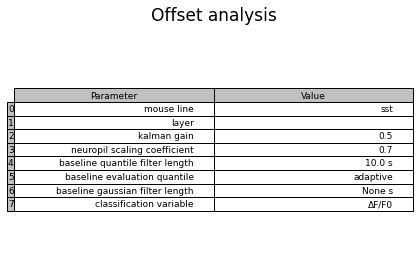

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'classification variable': ykey_classification
    }, title='Offset analysis')

### Load data

In [6]:
# Determine what to do in case of duplicate runs
on_duplicate_runs = 'pass'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, include_mode='any',
    on_duplicate_runs=on_duplicate_runs, harmonize_runs=False, 
    condition='offset')

 13/12/2022 13:36:34: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/classΔFF0/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/offset/sst:
 13/12/2022 13:36:34: loading trial-averaged data from 20190518_mouse6_region1.h5
 13/12/2022 13:36:35: loading trial-averaged data from 20190518_mouse7_region1.h5
 13/12/2022 13:36:35: loading trial-averaged data from 20190601_mouse2_region1.h5
 13/12/2022 13:36:35: loading trial-averaged data from 20190601_mouse7_region1.h5
 13/12/2022 13:36:35: loading trial-averaged data from 20190601_mouse8_region1.h5
 13/12/2022 13:36:35: gathering dataset IDs...
 13/12/2022 13:36:35: duplicated runs in 20190518_mouse7_region1:
run
0    0.0x_-1.5y
1    0.0x_-1.5y
Name: offset (mm), dtype: object
 13/12/2022 13:36:35: duplicated runs in 20190601_mouse7_region1:
run
4    0.0x_0.0y
5    0.0x_0.0y
Name: offset (mm), dtype: object
 13/12/2022 13:36:35: duplicated runs in 20190601_mouse

### Breakdown per mouse region, cell maps & filter out datasets

 13/12/2022 13:36:35: extracting timeseries and stats from data...
 13/12/2022 13:36:35: computing proportion of positive responses per dataset & condition...
 13/12/2022 13:36:35: excluding datasets with low responsiveness to "best" condition...
 13/12/2022 13:36:35: plotting cell maps...


4it [00:02,  1.39it/s]                       

 13/12/2022 13:36:38: identifying datasets to use for variable offset analysis...


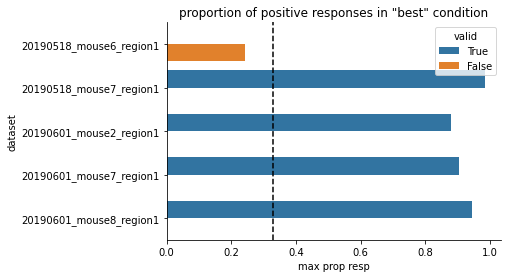

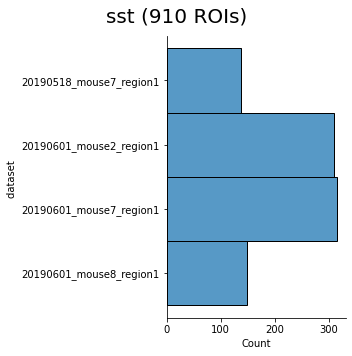

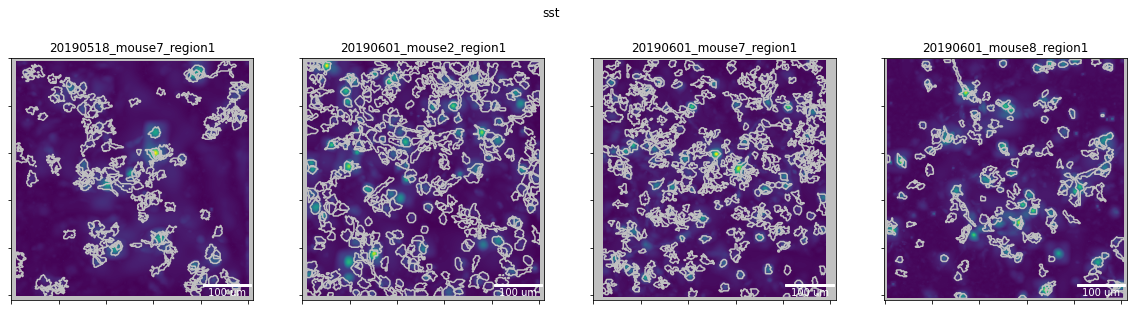

In [7]:
# Extract fields from data
timeseries, stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Compute proportion of positive responses for each dataset and condition
logger.info('computing proportion of positive responses per dataset & condition...')
respcounts = stats.groupby(
    [Label.DATASET, Label.RUN])[Label.RESP_TYPE].value_counts()
respprops = respcounts / respcounts.groupby([Label.DATASET, Label.RUN]).sum()
posprops = respprops.loc[pd.IndexSlice[:, :, 'positive']]

# Extract and plot max proportion of positive responses per dataset
maxposprops = posprops.groupby(Label.DATASET).max().rename('max prop resp').to_frame()
maxposprops['valid'] = maxposprops['max prop resp'] > OFFSET_MIN_PROP_POS
maxposprops[Label.DATASET] = maxposprops.index
figs['responsiveness_bestcond'], ax = plt.subplots()
ax.set_title('proportion of positive responses in "best" condition')
sns.despine(ax=ax)
sns.barplot(
    data=maxposprops, y=Label.DATASET, x='max prop resp', 
    hue='valid', hue_order=[True, False], ax=ax)
ax.axvline(OFFSET_MIN_PROP_POS, c='k', ls='--')
del maxposprops[Label.DATASET]

# Exclude datasets with less than 50% positive responses in "best" condition
logger.info('excluding datasets with low responsiveness to "best" condition...')
valid_datasets = maxposprops[maxposprops['valid']].index.values
timeseries = timeseries.loc[pd.IndexSlice[valid_datasets]]
stats = stats.loc[pd.IndexSlice[valid_datasets]]
ROI_masks = ROI_masks.loc[pd.IndexSlice[valid_datasets]]
map_ops = {k: map_ops[k] for k in valid_datasets}

# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    stats, hue=None, title=mouseline)
# Plot cell maps
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour', hue=None)

# Compute number of runs per dataset
logger.info('identifying datasets to use for variable offset analysis...')
nruns_per_dataset = stats.groupby([Label.DATASET]).apply(
    lambda df: len(df.index.unique(level=Label.RUN)))
# Identify datasets for variable offset analysis
varoffset_datasets = nruns_per_dataset.loc[nruns_per_dataset > 5].index.values.tolist()
idx_varoffset = pd.IndexSlice[varoffset_datasets]

### Parse XY locations and apply corrections to align max responses at origin

In [8]:
# Parse transducer XY coordinates
logger.info('parsing transducer XY offset coordinates...')
offsets_2d = get_offset_complex(stats)
stats['xoff (mm)'] = offsets_2d.apply(np.real)
stats['yoff (mm)'] = offsets_2d.apply(np.imag)

# Keys for coordinates and output metrics of interest
xykeys = ['xoff (mm)', 'yoff (mm)']
outkey = get_change_key(ykey_classification)

# Compute distance from XY coordinates
stats[Label.OFFSET] = np.linalg.norm(stats[xykeys], axis=1)

# For each dataset, get coordinates where max average response is observed
def get_max_xy(s):
    avg_per_loc = s[[*xykeys, outkey]].groupby(xykeys)[outkey].mean().reset_index()
    imax = avg_per_loc[outkey].argmax()
    return avg_per_loc.loc[imax, xykeys]
max_resp_offset_coords = stats.groupby(Label.DATASET).apply(get_max_xy)
logger.info(f'found max "{outkey}" values at offset coordinates:\n{max_resp_offset_coords}')
 
# Correct offset origins for each dataset (to have max response at origin)
logger.info(f'offsetting XY coordinates per dataset to align max {outkey} at origin...')
for k in xykeys:
    stats[k] = stats[k] - max_resp_offset_coords[k]

 13/12/2022 13:36:39: parsing transducer XY offset coordinates...
 13/12/2022 13:36:39: found max "evoked ΔF/F0 change" values at offset coordinates:
                         xoff (mm)  yoff (mm)
dataset                                      
20190518_mouse7_region1        0.0        0.0
20190601_mouse2_region1        0.5        0.0
20190601_mouse7_region1       -0.5        0.0
20190601_mouse8_region1       -1.0        0.0
 13/12/2022 13:36:39: offsetting XY coordinates per dataset to align max evoked ΔF/F0 change at origin...


### Inspect run sequences per dataset and potential consequences on evoked activity

 13/12/2022 13:36:40: plotting offset (mm) run sequence dependency across dataset...
 13/12/2022 13:36:40: run ID no part of (P (MPa), DC (%)) -> no filtering
 13/12/2022 13:36:40: sub-indexing data...
 13/12/2022 13:36:40: filtering data...
 13/12/2022 13:36:40: cross-checking filters...
 13/12/2022 13:36:40: grouping by dataset, averaging, estimating confidence intervals and plotting mean offset (mm) vs. run ID ...
 13/12/2022 13:36:40: plotting evoked ΔF/F0 change run sequence dependency across dataset...
 13/12/2022 13:36:40: run ID no part of (P (MPa), DC (%)) -> no filtering
 13/12/2022 13:36:40: sub-indexing data...
 13/12/2022 13:36:40: filtering data...
 13/12/2022 13:36:40: cross-checking filters...
 13/12/2022 13:36:40: grouping by dataset, averaging, estimating confidence intervals and plotting mean evoked ΔF/F0 change vs. run ID ...
 13/12/2022 13:36:41: offset sequences across datasets:


dataset,20190518_mouse7_region1,20190601_mouse2_region1,20190601_mouse7_region1,20190601_mouse8_region1
run ID,,,,
0,0.0x_0.0y,0.0x_0.0y,0.0x_0.0y,0.0x_0.0y
1,1.5x_0.0y,0.5x_0.0y,0.0x_0.0y,0.5x_0.0y
2,-1.5x_0.0y,1.0x_0.0y,0.5x_0.0y,1.0x_0.0y
3,0.0x_-1.5y,1.5x_0.0y,1.0x_0.0y,1.5x_0.0y
4,0.0x_-1.5y,2.0x_0.0y,1.5x_0.0y,2.0x_0.0y
5,NaN,2.0x_-1.0y,2.0x_0.0y,2.0x_-1.0y
6,NaN,-0.5x_0.0y,2.0x_-1.0y,-0.5x_0.0y
7,NaN,-1.0x_0.0y,-0.5x_0.0y,-1.0x_0.0y
8,NaN,-1.5x_0.0y,-1.0x_0.0y,-1.5x_0.0y


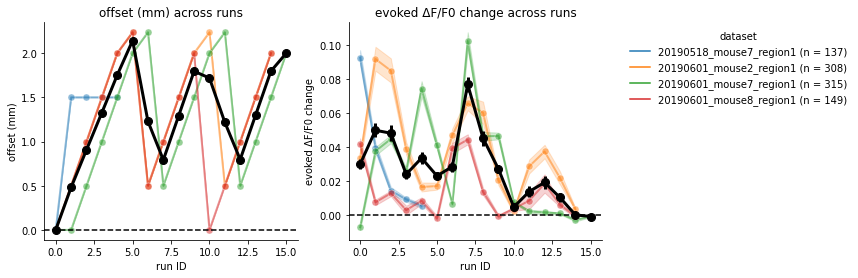

In [9]:
# Get parameter run sequence per dataset
offset_seqs = stats[[Label.RUNID, Label.SUFFIX]].groupby([Label.DATASET, Label.RUNID]).first()
offset_seqs = get_offset_code(offset_seqs).unstack().T

# Plot offset distance and evoked DFF across run sequences, per dataset
ykeys_plt = [Label.OFFSET, get_change_key(Label.DFF)]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(
    1, len(ykeys_plt), figsize=(5 * len(ykeys_plt), 4))
axes = np.atleast_1d(axes)
for i, (ykey, ax) in enumerate(zip(ykeys_plt, axes)):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        stats, xkey=Label.RUNID, ykey=ykey, yref=0., 
        hue=Label.DATASET, avgprop='whue', errprop='intra', ax=ax, 
        legend=i == len(ykeys_plt) - 1, title=f'{ykey} across runs')

logger.info('offset sequences across datasets:')
offset_seqs

### Plot response strength vs. XY offset

 13/12/2022 13:36:42: grouping stats by dataset...
 13/12/2022 13:36:42: plotting map of "evoked ΔF/F0 change" vs. XY offset...
 13/12/2022 13:36:42: grouping stats by dataset...
 13/12/2022 13:36:42: plotting map of "evoked ΔF/F0 change" vs. XY offset...


/Users/tlemaire/Documents/code/usnm2p/plotters.py:2911: RuntimeWarning: Mean of empty slice
  avgmap = np.nanmean(avgmap, axis=0)


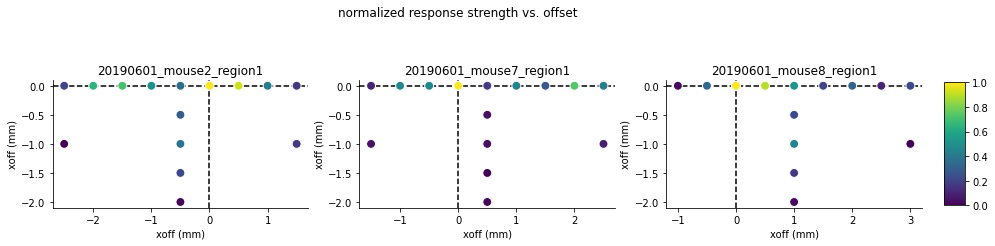

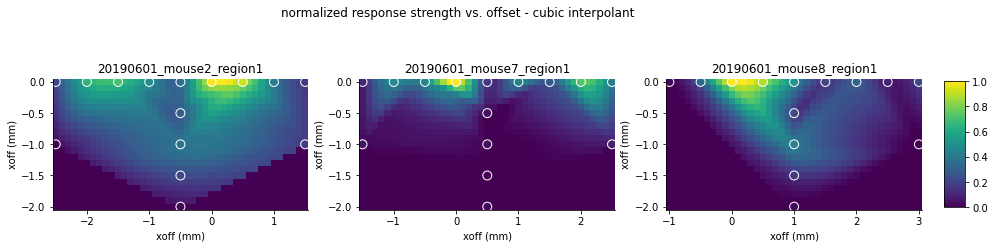

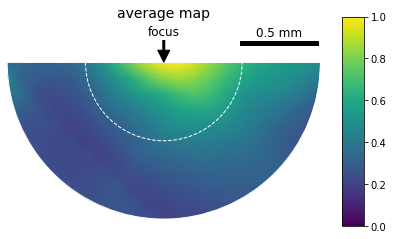

In [10]:
figs[f'resp_vs_offset_loc'] = plot_stat_vs_offset_map(
    stats.loc[idx_varoffset, :], *xykeys, outkey)
figs[f'resp_vs_offset_loc_maps'], figs[f'resp_vs_offset_loc_avgmap'] = plot_stat_vs_offset_map(
    stats.loc[idx_varoffset, :], *xykeys, outkey, interp='cubic', dx=0.1, dy=0.1)

### Plot response strength vs. normalized offset distance

 13/12/2022 13:36:42: plotting offset dependency of response...
 13/12/2022 13:36:42: corrected offset (mm) no part of (P (MPa), DC (%)) -> no filtering
 13/12/2022 13:36:42: sub-indexing data...
 13/12/2022 13:36:42: filtering data...
 13/12/2022 13:36:42: cross-checking filters...
 13/12/2022 13:36:42: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. corrected offset (mm) ...
 13/12/2022 13:36:42: rounded corrected offset (mm) no part of (P (MPa), DC (%)) -> no filtering
 13/12/2022 13:36:42: sub-indexing data...
 13/12/2022 13:36:42: filtering data...
 13/12/2022 13:36:42: cross-checking filters...
 13/12/2022 13:36:42: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. rounded corrected offset (mm) ...
 13/12/2022 13:36:43: plotting offset dependency of normalized response...
 13/12/2022 13:36:43: corrected offset (mm) no part of (P (MPa), DC (%)) -> no filtering
 13/12/2022 13:36:43: sub-indexing data...
 13/12/2022 13:36:43: filtering

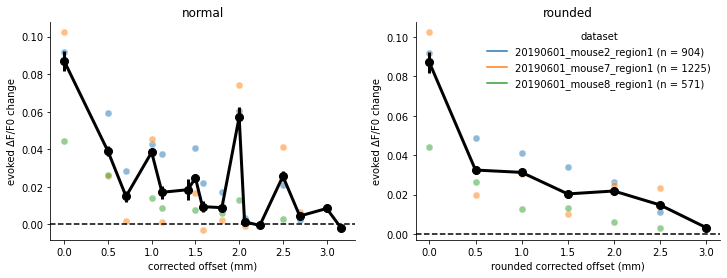

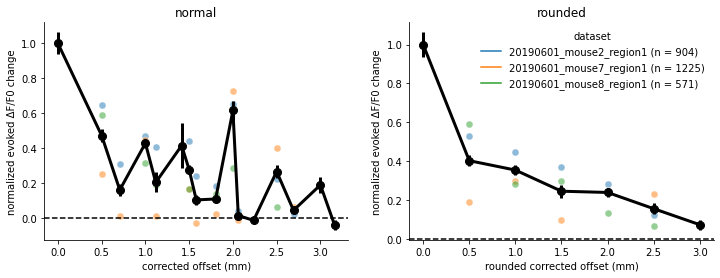

In [11]:
# Compute (corrected) offset distance as XY norm, and rounded to nearest .5 mm
dkey = f'corrected {Label.OFFSET}'
stats[dkey] = np.linalg.norm(stats[xykeys], axis=1)
rounded_dkey = f'rounded {dkey}'
stats[rounded_dkey] = stats[dkey].apply(round_to_base)

# Compute normalized response strength for each dataset
maxperdataset = stats.groupby([Label.DATASET, dkey])[outkey].mean().groupby(Label.DATASET).max()
normkey = f'normalized {outkey}'
stats[normkey] = stats[outkey] / maxperdataset

# Plot parameters
plt_kwargs = dict(
    yref=0.,
    hue=Label.DATASET,
    avgprop='whue',
    errprop='intra',
    ci=None, 
    lw=0,
)

# Plot response strength vs. distance
logger.info(f'plotting offset dependency of response...')
figs['resp_vs_offset'], axes = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax, k, title) in enumerate(zip(axes, [dkey, rounded_dkey], ['normal', 'rounded'])):
    plot_parameter_dependency(
        stats.loc[idx_varoffset, :], xkey=k, ykey=outkey, ax=ax,
        legend=i == len(axes) - 1, title=title, **plt_kwargs)

# Plot normalized response strength vs. distance
logger.info(f'plotting offset dependency of normalized response...')
figs['normresp_vs_offset'], axes = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax, k, title) in enumerate(zip(axes, [dkey, rounded_dkey], ['normal', 'rounded'])):
    plot_parameter_dependency(
        stats.loc[idx_varoffset, :], xkey=k, ykey=normkey, ax=ax,
        legend=i == len(axes) - 1, title=title, **plt_kwargs)

### Plot responders traces vs variable offset

 13/12/2022 13:36:43: assembling plot data...
 13/12/2022 13:36:44: adding time info to table...
 13/12/2022 13:36:44: plotting responders traces across offset & datasets...
 13/12/2022 13:36:49: plotting aggregate responders traces across offset...


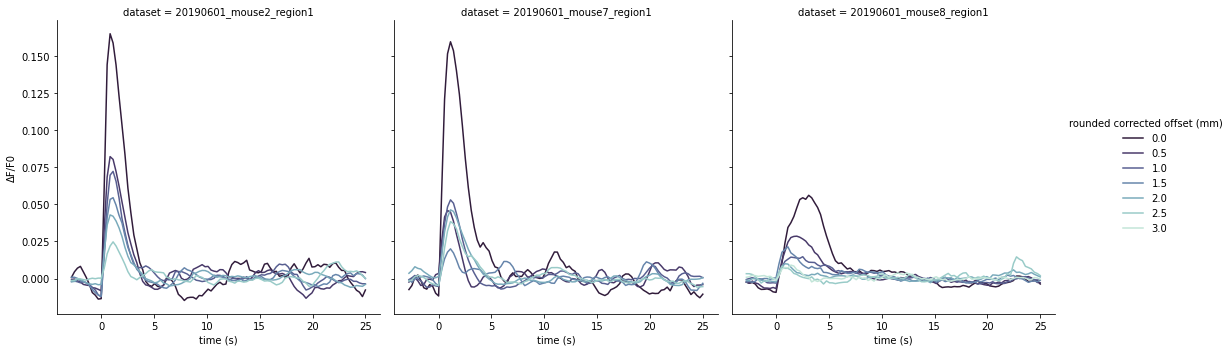

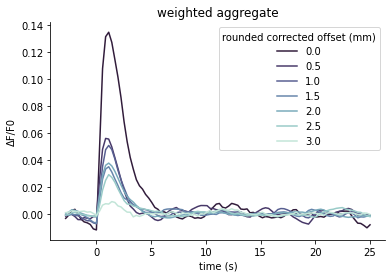

In [12]:
# Get plot data
logger.info('assembling plot data...')
pltdata = expand_and_add(
    stats[[Label.ROI_RESP_TYPE, rounded_dkey]], timeseries.copy())
# Add time
fps = get_singleton(stats, Label.FPS)
pltdata = add_time_to_table(pltdata, fps=fps)
# Restrict to variable offset datasets
pltdata = pltdata.loc[idx_varoffset, :]

# Plot parameters
plt_kwargs = dict(
    data=pltdata, 
    x=Label.TIME,
    y=Label.DFF,
    hue=rounded_dkey,
    ci=None,
    palette=Palette.OFFSET,
)

# Plot response traces vs. offset for each dataset
logger.info('plotting responders traces across offset & datasets...')
fg = sns.relplot(kind='line', col=Label.DATASET, **plt_kwargs)
figs['traces_vs_offset_per_dataset'] = fg.figure

# Plot weighted aggregate response traces vs. offset
logger.info('plotting aggregate responders traces across offset...')
figs['traces_vs_offset_agg'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('weighted aggregate')
sns.lineplot(ax=ax, **plt_kwargs);

### Plot comparison of centered vs. 1.5 mm offset

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

20190601_mouse2_region1_aligned vs. 20190601_mouse2_region1_1.5mm offset: Mann-Whitney-Wilcoxon test two-sided, P_val:2.606e-38 U_stat=1.793e+05
20190518_mouse7_region1_aligned vs. 20190518_mouse7_region1_1.5mm offset: Mann-Whitney-Wilcoxon test two-sided, P_val:8.050e-59 U_stat=7.008e+04
20190601_mouse7_region1_aligned vs. 20190601_mouse7_region1_1.5mm offset: Mann-Whitney-Wilcoxon test two-sided, P_val:8.135e-107 U_stat=2.618e+05
20190601_mouse8_region1_aligned vs. 20190601_mouse8_region1_1.5mm offset: Mann-Whitney-Wilcoxon test two-sided, P_val:5.793e-35 U_stat=3.408e+04


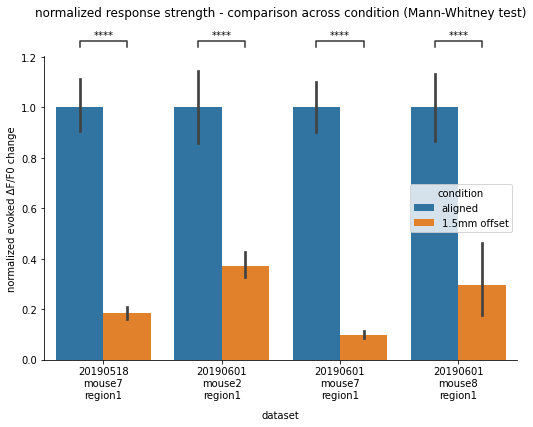

In [13]:
# Restrict dataset to center and 1.5 mm offset
fixed_offsets = (0., 1.5)  # comparative offset values (mm)
fixedstats = stats.copy()[stats[rounded_dkey].isin(fixed_offsets)]
# Create conditions column with better names
ckey = 'condition'
condkeys_map = {
    0.: 'aligned',
    1.5: '1.5mm offset'
}
fixedstats[ckey] = fixedstats[rounded_dkey].map(condkeys_map)

# Plot paired-comparisons of response strength between center and 1.5 mm offset
figs['paired_comps'] = plot_comparative_metrics_across_datasets(
    fixedstats, normkey, ckey, kind='bar', 
    hue_order=condkeys_map.values())

### Save figures

In [14]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 13/12/2022 13:36:53: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.12.13/figs_offset_sst_k0.5_alpha0.7_qadaptive_wq10.0s_classΔFF0.pdf:


100%|██████████| 13/13 [00:01<00:00,  7.41it/s]


### Notify upon completion

In [15]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 13/12/2022 13:36:55: sst batch notebook completed in 0:00:21.157105 s
